# Training a TensorFlow Autoencoder

This tutorial demonstrates how to train an image classifier using the [Ray AI Runtime](air) (AIR).

You should be familiar with TensorFlow before starting this tutorial. If you need a refresher, read Keras's [Building Autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html) tutorial.

## Before you begin

* Install the [Ray AI Runtime](air). You'll need Ray 1.13 or later to run this example.

In [ ]:
#!pip install 'ray[air]'

* Install `tensorflow` and `tensorflow-datasets`

In [ ]:
#!pip install tensorflow tensorflow-datasets

## Load and normalize mnist

We'll train our classifier on a toy image dataset called [MNIST](http://yann.lecun.com/exdb/mnist/).

First, let's load mnist into a Ray Dataset.

In [1]:
import ray
from ray.data.datasource import SimpleTensorFlowDatasource
import tensorflow as tf

from tensorflow.keras import layers, models
import tensorflow_datasets as tfds


def train_dataset_factory():
    return tfds.load("mnist", split=["train"], as_supervised=True)[0]

def test_dataset_factory():
    return tfds.load("mnist", split=["test"], as_supervised=True)[0]

train_dataset = ray.data.read_datasource(
    SimpleTensorFlowDatasource(), dataset_factory=train_dataset_factory
)
test_dataset = ray.data.read_datasource(
    SimpleTensorFlowDatasource(), dataset_factory=test_dataset_factory
)

train_dataset

2022-05-30 22:46:14,969	INFO services.py:1478 -- View the Ray dashboard at http://127.0.0.1:8266
2022-05-30 22:46:18,508	WARNING read_api.py:252 -- The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
(_prepare_read pid=1015) 2022-05-30 22:46:18,504	WARNING tensorflow_datasource.py:53 -- `SimpleTensorFlowDatasource` doesn't support parallel reads. The `parallelism` argument will be ignored.
(_execute_read_task pid=1015) 2022-05-30 22:46:18.669025: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-30 22:46:26,966	WARNING read_api.py:252 -- The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increas

Dataset(num_blocks=1, num_rows=60000, schema=<class 'tuple'>)

Note that {py:class}`SimpleTensorFlowDatasource <ray.data.datasource.SimpleTensorFlowDatasource>` loads all data into memory, so you shouldn't use it with larger datasets.

In the preprocessing, we first standardize the image inputs by normalizing the pixel value between 0 and 1. 

In [2]:
import numpy as np
def normalize_images(x):
    x = np.float32(x.numpy()) / 255.0
    x = np.reshape(x, (-1,))
    return x

def preprocess_dataset(batch):
    return [(normalize_images(image), normalize_images(image)) for image, _ in batch]

train_dataset = train_dataset.map_batches(preprocess_dataset)
test_dataset = test_dataset.map_batches(preprocess_dataset)

Read->Map_Batches: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



Next, let's represent our data using pandas dataframes. This is an standard preprocessing step to use `Ray.dataset`. Then, methods like {py:meth}`Dataset.to_tf <ray.data.Dataset.to_tf>` can be called later in the tutorial.

**Note**: When we are training an autoencoder, it tries to reconstruct the input images. Therefore, the output "labels"s are still the input images. This is a simple example of self-supervised learning, i.e. the training only makes use of the input dataset without using the label information. Self-supervised learning becomes more and more important these days because usually we have lots of datasets but labels require lots of human effort and expertise. Self-supervised learning utilizes the dataset alone, and learns meaningful latent representation, which can be useful for other downstream tasks.

In [3]:
import pandas as pd
from ray.data.extensions import TensorArray

def convert_batch_to_pandas(batch):
    images = [TensorArray(image) for image, _ in batch]

    df = pd.DataFrame({"image": images, "label": images})
    return df

train_dataset = train_dataset.map_batches(convert_batch_to_pandas)
test_dataset = test_dataset.map_batches(convert_batch_to_pandas)

test_dataset

Map_Batches: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Dataset(num_blocks=1, num_rows=10000, schema={image: object, label: object})

## Build a fully connected neural network

Before diving into the training neural networks, let's first build an autoencoder network. The simplest examples uses the fully connected layers. 

**Note**: the last activation function is `sigmoid` because we tries to interpret the output as the probility of getting the pixel value of 1, so that the training loss is therefore defined as the cross entropy loss.  

In [4]:
def build_autoencoder_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(784,)),
            # encoder
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            # decoder
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(784, activation="sigmoid"),
        ]
    )
    return model

Now that we've created our neural network, let's define the training logic in a function called `train_func`.

`train_func` contains regular TensorFlow code with a few notable exceptions:
* We build and compile our model in the [`MultiWorkerMirrioredStrategy`](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/MultiWorkerMirroredStrategy) context.
* We call {py:func}`session.get_dataset_shard <ray.air.session.get_dataset_shard>` to get a subset of our training data, and call {py:meth}`Dataset.to_tf <ray.data.Dataset.to_tf>` with {py:func}`prepare_dataset_shard <ray.train.tensorflow.prepare_dataset_shard>` to convert the subset to a TensorFlow dataset.
* We use the {py:class}`ray.air.callbacks.keras.Callback <ray.air.callbacks.keras.Callback>` for metric reporting and checkpointing.


In [5]:
import os
import json
from ray.air import session
from ray.air.callbacks.keras import Callback
from ray.train.tensorflow import prepare_dataset_shard

def train_func(config: dict):

    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)

    tf_config = json.loads(os.environ["TF_CONFIG"])
    num_workers = len(tf_config["cluster"]["worker"])

    dataset_shard = session.get_dataset_shard("train")

    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_autoencoder_model()
        learning_rate = config.get("lr", 0.001)
        multi_worker_model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=["binary_crossentropy",],
        )

    results = []
    for epoch in range(epochs):
        tf_dataset = prepare_dataset_shard(
            dataset_shard.to_tf(
                feature_columns=["image"],
                label_column="label",
                output_signature=(
                    tf.TensorSpec(shape=(None, 784), dtype=tf.float32),
                    tf.TensorSpec(shape=(None, 784), dtype=tf.float32),
                ),
                batch_size=per_worker_batch_size,
            )
        )
        history = multi_worker_model.fit(
            tf_dataset, callbacks=[Callback()]
        )
        results.append(history.history)
    return results

Finally, we can train our model. This should take a few minutes to run.

In [6]:
from ray.train.tensorflow import TensorflowTrainer
from ray.air.result import Result

def train_tensorflow_mnist(
    num_workers: int = 2, use_gpu: bool = False, epochs: int = 4
) -> Result:
    config = {"lr": 1e-3, "batch_size": 64, "epochs": epochs}
    scaling_config = dict(num_workers=num_workers, use_gpu=use_gpu)
    trainer = TensorflowTrainer(
        train_loop_per_worker=train_func,
        train_loop_config=config,
        datasets={"train": train_dataset},
        scaling_config=scaling_config,
    )

    results = trainer.fit()
    print(results.metrics)
    return results

result = train_tensorflow_mnist(num_workers=2, use_gpu=False, epochs=10)

2022-05-30 22:46:50,543	INFO data_parallel_trainer.py:273 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


Trial name,status,loc,iter,total time (s),loss,binary_crossentropy,_timestamp
TensorflowTrainer_64ebc_00000,TERMINATED,10.0.2.132:3333,10,78.3056,0.0881403,0.0881403,1653950892


(raylet) 2022-05-30 22:46:51,544	INFO context.py:70 -- Exec'ing worker with command: exec /home/ubuntu/anaconda3/envs/tensorflow2_p38/bin/python /home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/ray/workers/default_worker.py --node-ip-address=10.0.2.132 --node-manager-port=33095 --object-store-name=/tmp/ray/session_2022-05-30_22-46-12_694173_770/sockets/plasma_store --raylet-name=/tmp/ray/session_2022-05-30_22-46-12_694173_770/sockets/raylet --redis-address=None --storage=None --temp-dir=/tmp/ray --metrics-agent-port=62150 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=10.0.2.132:45547 --redis-password=5241590000000000 --startup-token=49 --runtime-env-hash=-674568276
(TrainTrainable pid=3333) 2022-05-30 22:46:54,458	INFO data_parallel_trainer.py:273 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(raylet) 20

      8/Unknown - 3s 8ms/step - loss: 0.6701 - binary_crossentropy: 0.6701
      8/Unknown - 3s 8ms/step - loss: 0.6701 - binary_crossentropy: 0.6701
     23/Unknown - 3s 7ms/step - loss: 0.4989 - binary_crossentropy: 0.4989
     23/Unknown - 3s 7ms/step - loss: 0.4989 - binary_crossentropy: 0.4989
     39/Unknown - 4s 7ms/step - loss: 0.4116 - binary_crossentropy: 0.4116
     39/Unknown - 4s 7ms/step - loss: 0.4116 - binary_crossentropy: 0.4116
     55/Unknown - 4s 7ms/step - loss: 0.3702 - binary_crossentropy: 0.3702
     55/Unknown - 4s 7ms/step - loss: 0.3702 - binary_crossentropy: 0.3702
     71/Unknown - 4s 7ms/step - loss: 0.3451 - binary_crossentropy: 0.3451
     71/Unknown - 4s 7ms/step - loss: 0.3451 - binary_crossentropy: 0.3451
     87/Unknown - 4s 7ms/step - loss: 0.3280 - binary_crossentropy: 0.3280
     87/Unknown - 4s 7ms/step - loss: 0.3280 - binary_crossentropy: 0.3280
    103/Unknown - 4s 7ms/step - loss: 0.3142 - binary_crossentropy: 0.3142
    103/Unknown - 4s 7ms/

    725/Unknown - 8s 7ms/step - loss: 0.1818 - binary_crossentropy: 0.1818
    725/Unknown - 8s 7ms/step - loss: 0.1818 - binary_crossentropy: 0.1818
    741/Unknown - 8s 7ms/step - loss: 0.1808 - binary_crossentropy: 0.1808
    741/Unknown - 8s 7ms/step - loss: 0.1808 - binary_crossentropy: 0.1808
    757/Unknown - 8s 7ms/step - loss: 0.1798 - binary_crossentropy: 0.1798
    757/Unknown - 8s 7ms/step - loss: 0.1798 - binary_crossentropy: 0.1798
    773/Unknown - 8s 7ms/step - loss: 0.1789 - binary_crossentropy: 0.1789
    773/Unknown - 8s 7ms/step - loss: 0.1789 - binary_crossentropy: 0.1789
    789/Unknown - 9s 7ms/step - loss: 0.1779 - binary_crossentropy: 0.1779
    789/Unknown - 9s 7ms/step - loss: 0.1779 - binary_crossentropy: 0.1779
    805/Unknown - 9s 7ms/step - loss: 0.1770 - binary_crossentropy: 0.1770
    805/Unknown - 9s 7ms/step - loss: 0.1770 - binary_crossentropy: 0.1770
    821/Unknown - 9s 7ms/step - loss: 0.1761 - binary_crossentropy: 0.1761
    821/Unknown - 9s 7ms/

    496/Unknown - 4s 7ms/step - loss: 0.1202 - binary_crossentropy: 0.1202
    496/Unknown - 4s 7ms/step - loss: 0.1202 - binary_crossentropy: 0.1202
    512/Unknown - 4s 7ms/step - loss: 0.1201 - binary_crossentropy: 0.1201
    512/Unknown - 4s 7ms/step - loss: 0.1201 - binary_crossentropy: 0.1201
    528/Unknown - 4s 7ms/step - loss: 0.1199 - binary_crossentropy: 0.1199
    528/Unknown - 4s 7ms/step - loss: 0.1199 - binary_crossentropy: 0.1199
    544/Unknown - 4s 7ms/step - loss: 0.1197 - binary_crossentropy: 0.1197
    544/Unknown - 4s 7ms/step - loss: 0.1197 - binary_crossentropy: 0.1197
    560/Unknown - 4s 7ms/step - loss: 0.1196 - binary_crossentropy: 0.1196
    560/Unknown - 4s 7ms/step - loss: 0.1196 - binary_crossentropy: 0.1196
    576/Unknown - 4s 7ms/step - loss: 0.1194 - binary_crossentropy: 0.1194
    576/Unknown - 4s 7ms/step - loss: 0.1194 - binary_crossentropy: 0.1194
    592/Unknown - 4s 7ms/step - loss: 0.1192 - binary_crossentropy: 0.1192
    592/Unknown - 4s 7ms/

    279/Unknown - 2s 7ms/step - loss: 0.1080 - binary_crossentropy: 0.1080
    279/Unknown - 2s 7ms/step - loss: 0.1080 - binary_crossentropy: 0.1080
    295/Unknown - 2s 7ms/step - loss: 0.1078 - binary_crossentropy: 0.1078
    295/Unknown - 2s 7ms/step - loss: 0.1078 - binary_crossentropy: 0.1078
    310/Unknown - 2s 7ms/step - loss: 0.1078 - binary_crossentropy: 0.1078
    310/Unknown - 2s 7ms/step - loss: 0.1078 - binary_crossentropy: 0.1078
    326/Unknown - 3s 7ms/step - loss: 0.1077 - binary_crossentropy: 0.1077
    326/Unknown - 3s 7ms/step - loss: 0.1077 - binary_crossentropy: 0.1077
    342/Unknown - 3s 7ms/step - loss: 0.1075 - binary_crossentropy: 0.1075
    342/Unknown - 3s 7ms/step - loss: 0.1075 - binary_crossentropy: 0.1075
    358/Unknown - 3s 7ms/step - loss: 0.1075 - binary_crossentropy: 0.1075
    358/Unknown - 3s 7ms/step - loss: 0.1075 - binary_crossentropy: 0.1075
    374/Unknown - 3s 7ms/step - loss: 0.1074 - binary_crossentropy: 0.1074
    374/Unknown - 3s 7ms/

     32/Unknown - 1s 7ms/step - loss: 0.1022 - binary_crossentropy: 0.1022
     32/Unknown - 1s 7ms/step - loss: 0.1022 - binary_crossentropy: 0.1022
     48/Unknown - 1s 7ms/step - loss: 0.1026 - binary_crossentropy: 0.1026
     48/Unknown - 1s 7ms/step - loss: 0.1026 - binary_crossentropy: 0.1026
     64/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     64/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     80/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     80/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     88/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     88/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     96/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
     96/Unknown - 1s 7ms/step - loss: 0.1025 - binary_crossentropy: 0.1025
    104/Unknown - 1s 7ms/step - loss: 0.1024 - binary_crossentropy: 0.1024
    104/Unknown - 1s 7ms/

    830/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    830/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    846/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    846/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    862/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    862/Unknown - 6s 7ms/step - loss: 0.0999 - binary_crossentropy: 0.0999
    878/Unknown - 6s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    878/Unknown - 6s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    894/Unknown - 6s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    894/Unknown - 6s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    910/Unknown - 7s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    910/Unknown - 7s 7ms/step - loss: 0.0998 - binary_crossentropy: 0.0998
    918/Unknown - 7s 7ms/step - loss: 0.0997 - binary_crossentropy: 0.0997
    918/Unknown - 7s 7ms/

    590/Unknown - 4s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    590/Unknown - 4s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    605/Unknown - 4s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    605/Unknown - 4s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    619/Unknown - 5s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    619/Unknown - 5s 7ms/step - loss: 0.0966 - binary_crossentropy: 0.0966
    635/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    635/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    651/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    651/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    667/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    667/Unknown - 5s 7ms/step - loss: 0.0965 - binary_crossentropy: 0.0965
    683/Unknown - 5s 7ms/step - loss: 0.0964 - binary_crossentropy: 0.0964
    683/Unknown - 5s 7ms/

    399/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    398/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    415/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    414/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    431/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    430/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    439/Unknown - 3s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    446/Unknown - 3s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    455/Unknown - 3s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    454/Unknown - 3s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    462/Unknown - 3s 7ms/step - loss: 0.0943 - binary_crossentropy: 0.0943
    471/Unknown - 4s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    470/Unknown - 3s 7ms/step - loss: 0.0942 - binary_crossentropy: 0.0942
    478/Unknown - 4s 7ms/

    160/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    160/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    168/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    168/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    176/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    176/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    191/Unknown - 2s 7ms/step - loss: 0.0929 - binary_crossentropy: 0.0929
    191/Unknown - 2s 7ms/step - loss: 0.0929 - binary_crossentropy: 0.0929
    199/Unknown - 2s 7ms/step - loss: 0.0929 - binary_crossentropy: 0.0929
    199/Unknown - 2s 7ms/step - loss: 0.0929 - binary_crossentropy: 0.0929
    215/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    215/Unknown - 2s 7ms/step - loss: 0.0928 - binary_crossentropy: 0.0928
    231/Unknown - 2s 7ms/step - loss: 0.0927 - binary_crossentropy: 0.0927
    231/Unknown - 2s 7ms/

938/938 [==============================] - 7s 7ms/step - loss: 0.0919 - binary_crossentropy: 0.0919
      8/Unknown - 0s 7ms/step - loss: 0.0897 - binary_crossentropy: 0.0897  
      8/Unknown - 0s 7ms/step - loss: 0.0897 - binary_crossentropy: 0.0897  
     16/Unknown - 0s 7ms/step - loss: 0.0907 - binary_crossentropy: 0.0907
     16/Unknown - 0s 7ms/step - loss: 0.0907 - binary_crossentropy: 0.0907
     32/Unknown - 1s 7ms/step - loss: 0.0913 - binary_crossentropy: 0.0913
     32/Unknown - 1s 7ms/step - loss: 0.0913 - binary_crossentropy: 0.0913
     48/Unknown - 1s 7ms/step - loss: 0.0916 - binary_crossentropy: 0.0916
     48/Unknown - 1s 7ms/step - loss: 0.0916 - binary_crossentropy: 0.0916
     64/Unknown - 1s 7ms/step - loss: 0.0914 - binary_crossentropy: 0.0914
     64/Unknown - 1s 7ms/step - loss: 0.0914 - binary_crossentropy: 0.0914
     80/Unknown - 1s 7ms/step - loss: 0.0915 - binary_crossentropy: 0.0915
     80/Unknown - 1s 7ms/step - loss: 0.0915 - binary_crossentropy: 0.0

    788/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    788/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    804/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    804/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    812/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    812/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    820/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    820/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    828/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    828/Unknown - 6s 7ms/step - loss: 0.0906 - binary_crossentropy: 0.0906
    844/Unknown - 6s 7ms/step - loss: 0.0905 - binary_crossentropy: 0.0905
    844/Unknown - 6s 7ms/step - loss: 0.0905 - binary_crossentropy: 0.0905
    860/Unknown - 6s 7ms/step - loss: 0.0905 - binary_crossentropy: 0.0905
    860/Unknown - 6s 7ms/

    579/Unknown - 4s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    579/Unknown - 4s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    594/Unknown - 4s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    594/Unknown - 4s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    608/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    608/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    622/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    622/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    638/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    638/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    654/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    654/Unknown - 5s 7ms/step - loss: 0.0894 - binary_crossentropy: 0.0894
    670/Unknown - 5s 7ms/step - loss: 0.0893 - binary_crossentropy: 0.0893
    670/Unknown - 5s 7ms/

    368/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    368/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    384/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    384/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    400/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    400/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    416/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    416/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    432/Unknown - 3s 7ms/step - loss: 0.0884 - binary_crossentropy: 0.0884
    432/Unknown - 3s 7ms/step - loss: 0.0884 - binary_crossentropy: 0.0884
    448/Unknown - 3s 7ms/step - loss: 0.0884 - binary_crossentropy: 0.0884
    448/Unknown - 3s 7ms/step - loss: 0.0884 - binary_crossentropy: 0.0884
    464/Unknown - 3s 7ms/step - loss: 0.0885 - binary_crossentropy: 0.0885
    464/Unknown - 3s 7ms/

2022-05-30 22:48:13,565	INFO tune.py:752 -- Total run time: 83.00 seconds (82.45 seconds for the tuning loop).


{'loss': 0.08814025670289993, 'binary_crossentropy': 0.08814025670289993, '_timestamp': 1653950892, '_time_this_iter_s': 6.96003532409668, '_training_iteration': 10, 'time_this_iter_s': 6.960082054138184, 'should_checkpoint': True, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 10, 'trial_id': '64ebc_00000', 'experiment_id': '793e65e7230a463f9e0c4d8f7ffaaf18', 'date': '2022-05-30_22-48-12', 'timestamp': 1653950892, 'time_total_s': 78.30563044548035, 'pid': 3333, 'hostname': 'ip-10-0-2-132', 'node_ip': '10.0.2.132', 'config': {}, 'time_since_restore': 78.30563044548035, 'timesteps_since_restore': 0, 'iterations_since_restore': 10, 'warmup_time': 0.003418445587158203, 'experiment_tag': '0'}


To scale your training script, create a [Ray Cluster](deployment-guide) and increase the number of workers. If your cluster contains GPUs, add `"use_gpu": True` to your scaling config.

In [ ]:
# result = train_tensorflow_mnist(num_workers=8, use_gpu=True, epochs=10)

## visualize the network performance on the test data

Let's see how our model performs.

To classify images in the test dataset, we'll need to create a {py:class}`Predictor <ray.ml.predictor.Predictor>`.

{py:class}`Predictors <ray.ml.predictor.Predictor>` load data from checkpoints and efficiently perform inference. In contrast to {py:class}`TensorflowPredictor <ray.ml.predictors.integrations.tensorflow.TensorflowPredictor>`, which performs inference on a single batch, {py:class}`BatchPredictor <ray.ml.batch_predictor.BatchPredictor>` performs inference on an entire dataset. Because we want to classify all of the images in the test dataset, we'll use a {py:class}`BatchPredictor <ray.ml.batch_predictor.BatchPredictor>`.


In [9]:
from ray.air.predictors.integrations.tensorflow import TensorflowPredictor
from ray.air.batch_predictor import BatchPredictor

batch_predictor = BatchPredictor.from_checkpoint(
    result.checkpoint, TensorflowPredictor, model_definition=build_autoencoder_model
)

# test_dataset.
predictions = batch_predictor.predict(
    test_dataset, feature_columns=["image"], dtype=tf.float32
)

Map Progress (1 actors 1 pending): 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


Our models reconstructs the input for each input image. To see the performance of autoencoders, we use the following scripts to make a plot.

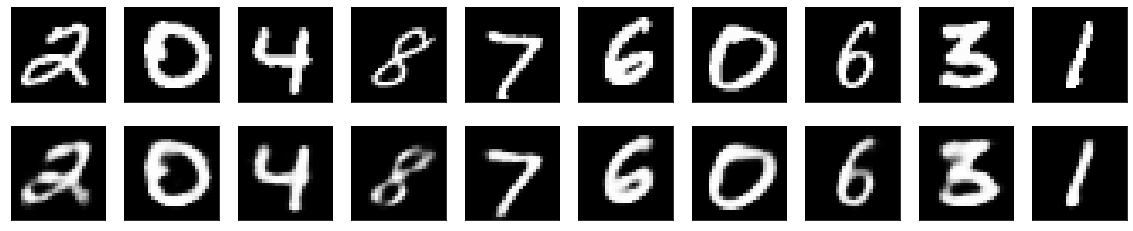

In [10]:
pandas_predictions = predictions.to_pandas(float("inf"))

decoded_imgs = pandas_predictions["predictions"].values
x_test = test_dataset.to_pandas(float("inf"))["image"].values

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.asarray(x_test[i]).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.asarray(decoded_imgs[i]).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# how to retrieve the folderpath of the checkpoint
plt.show()